In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Jewelry_Dataset.csv')
data.columns = ['order_datetime', 'order_id',
                'product_id',
                'sku_quantity',
                'category_id',
                'category',
                'brand_id',
                'price_usd',
                'user_id',
                'target_gender',
                'main_color',
                'main_gem',
                'main_metal']
data.head()

,order_datetime,order_id,product_id,sku_quantity,category_id,category,brand_id,price_usd,user_id,target_gender,main_color,main_gem,main_metal
0,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
1,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
2,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond
3,2018-12-02 21:30:19 UTC,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst
4,2018-12-02 22:09:34 UTC,1925760595336888995,1835566854827934449,1,1.806829e+18,jewelry.earring,1.0,102.27,1.515916e+18,NaN,red,gold,NaN


In [5]:
data.shape

(95910, 13)

In [6]:

data.isnull().sum()

order_datetime        0
order_id              0
product_id            0
sku_quantity          0
category_id        5352
category           9933
brand_id           4785
price_usd          5352
user_id            5352
target_gender     48167
main_color         7660
main_gem           5462
main_metal        34058
dtype: int64

In [7]:
data.nunique() #this is for feature cardinality. how many unique features a value can take

order_datetime    74504
order_id          74759
product_id         9613
sku_quantity          1
category_id          25
category            218
brand_id           2537
price_usd          3166
user_id           31079
target_gender         2
main_color            5
main_gem              3
main_metal           30
dtype: int64

In [8]:
data.describe()

,order_id,product_id,sku_quantity,category_id,brand_id,price_usd,user_id
count,9.591000e+04,9.591000e+04,95910.0,9.055800e+04,9.112500e+04,90558.000000,9.055800e+04
mean,2.485191e+18,1.815970e+18,1.0,1.805947e+18,8.891036e+16,362.213017,1.512644e+18
std,1.934750e+17,2.136814e+17,0.0,2.083954e+16,3.559651e+17,444.157665,2.374776e+16
min,1.924899e+18,1.313551e+18,1.0,1.313678e+18,0.000000e+00,0.990000,1.313554e+18
25%,2.379732e+18,1.515966e+18,1.0,1.806829e+18,0.000000e+00,145.620000,1.515916e+18
50%,2.524282e+18,1.956664e+18,1.0,1.806829e+18,1.000000e+00,258.770000,1.515916e+18
75%,2.644347e+18,1.956664e+18,1.0,1.806829e+18,1.000000e+00,431.370000,1.515916e+18
max,2.719022e+18,2.541962e+18,1.0,1.806829e+18,1.550613e+18,34448.600000,1.554297e+18


In [9]:
#checking for duplicate values
num_duplicated = len(data.loc[data.duplicated()])
print(f"Number of duplicated records are", num_duplicated) #this would have to be eliminated

Number of duplicated records are 2589


In [10]:
#features with a single cardinality. This will be dropped as it isn't quite useful for us
invariant_features = data.nunique()[data.nunique() == 1].index.tolist() #this picks out the rows and columns that have single features
invariant_features

['sku_quantity']

In [11]:
#understanding our label description and skewness of the data
data['price_usd'].skew() #our data is likely heavily right skewed.

18.95906072625981

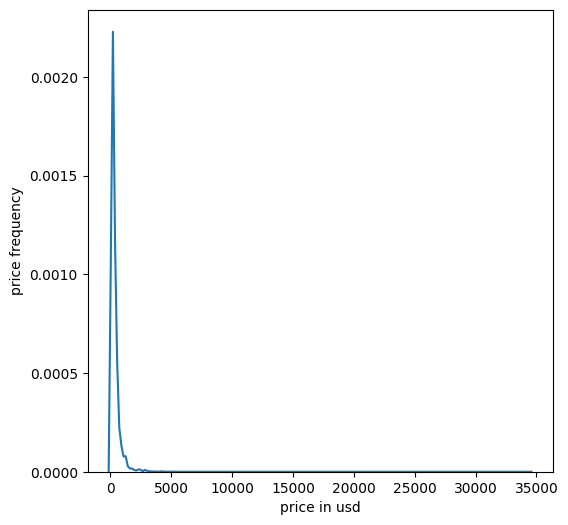

In [12]:
#visualize the price distribution via histogram / distribution map
plt.figure(figsize = (6,6))
sns.kdeplot(data=data, x='price_usd')
plt.xlabel('price in usd')
plt.ylabel('price frequency');

In [13]:
#from the chart above, the distribution is quite sharp. we go ahead and check for the kurtosis
data['price_usd'].kurtosis() #a high kurtosis means that the price_usd data has very heavy tails and a sharp peak.
#In practical terms, this suggests that there are many extreme values or outliers in the price_usd column, far more than would be expected in a normal distribution.

1054.8979068506155

In [14]:
#target gender analysis. Here we are analyzing the relationship between our target gender and the jewelry
data['target_gender'].value_counts()

target_gender
f    47379
m      364
Name: count, dtype: int64

In [15]:
#to have the above in a normalized form
data['target_gender'].value_counts(normalize = True)

target_gender
f    0.992376
m    0.007624
Name: proportion, dtype: float64

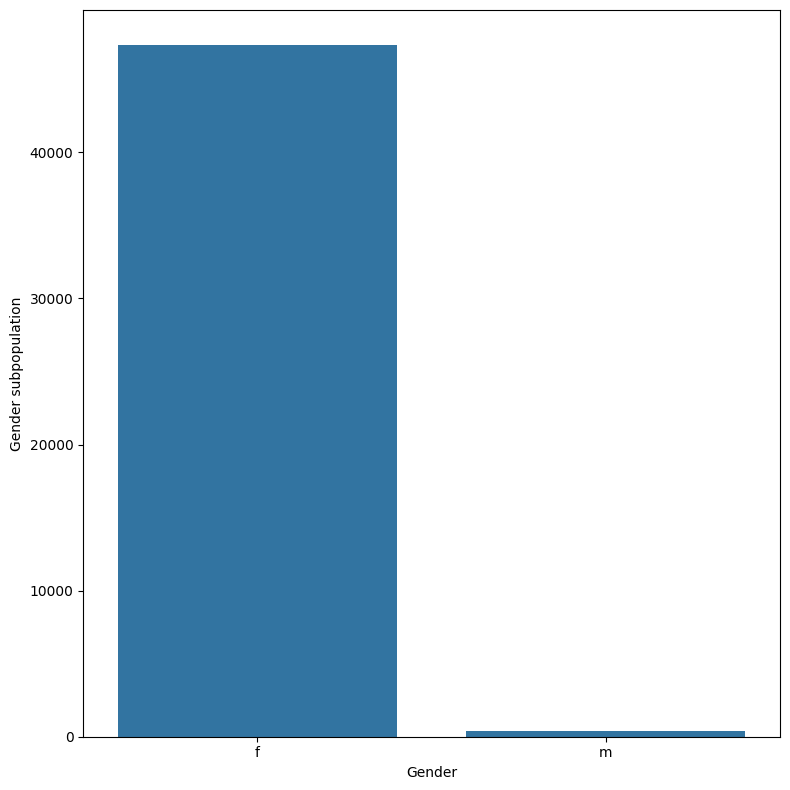

In [16]:
#visualize target gender
plt.figure(figsize = (8,8))
sns.countplot(data = data, x ='target_gender')
plt.xlabel('Gender')
plt.ylabel('Gender subpopulation')
plt.tight_layout() #it can be seen that it is heavily skewed towards women and it is worth taking into consideration

In [17]:
#jewelry category analysis
data['category'].value_counts() #presence of corrupted data

category
jewelry.earring     29051
jewelry.ring        28300
jewelry.pendant     13088
jewelry.bracelet     6188
0.00                 4392
                    ...  
626.58                  1
13.42                   1
2.88                    1
101.23                  1
253.77                  1
Name: count, Length: 218, dtype: int64

In [18]:
data['category'].unique() #a lot of values that are not useful and will be removed

array([nan, 'jewelry.pendant', 'jewelry.necklace', 'jewelry.earring',
       'jewelry.ring', 'jewelry.brooch', 'jewelry.bracelet',
       'electronics.clocks', 'jewelry.souvenir', '230.12', '202.36',
       '1098.03', '321.78', '1128.62', '81.27', '34.25', '582.16',
       '227.37', '234.22', '150.55', '131.82', '2123.15', '109.45',
       '49.22', '472.47', '205.38', '2746.44', '51.08', '231.12', '76.97',
       '3054.73', '184.90', '380.10', '357.49', '15.47', '135.33',
       '719.75', '93.01', '177.95', 'jewelry.stud', '102.10', '595.75',
       '469.56', '427.07', '53.62', '77.53', '1469.18', '355.27',
       '184.89', '154.66', '300.58', '83.73', '271.19', '3294.21',
       '278.04', '3626.26', '126.03', '283.52', '114.38', '89.04', '8.22',
       '124.88', '89.73', '171.23', '136.93', '19.04', '158.77', '187.10',
       '151.92', '1845.89', '87.23', '248.58', '596.48', '208.88',
       '193.11', '169.84', '1447.68', '45.07', '136.85', '282.05',
       '61.51', '210.21', '137.12'

In [19]:
#Extract the actual categories
categories = data['category'].unique().tolist()
categories = [c for c in categories if isinstance(c, str) and 'jewelry' in c]
categories

['jewelry.pendant',
 'jewelry.necklace',
 'jewelry.earring',
 'jewelry.ring',
 'jewelry.brooch',
 'jewelry.bracelet',
 'jewelry.souvenir',
 'jewelry.stud']

In [20]:
#pick out the authentic data based on the categories
real_categories = data.loc[data['category'].isin(categories)]
real_categories

,order_datetime,order_id,product_id,sku_quantity,category_id,category,brand_id,price_usd,user_id,target_gender,main_color,main_gem,main_metal
1,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
2,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond
3,2018-12-02 21:30:19 UTC,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst
4,2018-12-02 22:09:34 UTC,1925760595336888995,1835566854827934449,1,1.806829e+18,jewelry.earring,1.0,102.27,1.515916e+18,NaN,red,gold,NaN
5,2018-12-02 22:09:34 UTC,1925760595336888995,1600021442638905547,1,1.806829e+18,jewelry.earring,0.0,150.55,1.515916e+18,NaN,red,gold,diamond
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95900,2021-12-01 09:32:35 UTC,2719009022110859402,1956663836207481431,1,1.806829e+18,jewelry.ring,0.0,145.62,1.515916e+18,NaN,red,gold,NaN
95903,2021-12-01 09:37:28 UTC,2719011482355368159,1956663847389495299,1,1.806829e+18,jewelry.earring,0.0,301.23,1.515916e+18,NaN,red,gold,amethyst
95907,2021-12-01 09:52:06 UTC,2719018846999544322,1956663848219968336,1,1.806829e+18,jewelry.earring,1.0,630.00,1.515916e+18,f,white,gold,diamond
95908,2021-12-01 09:55:35 UTC,2719020596963836492,1835566854106513435,1,1.806829e+18,jewelry.earring,0.0,83.42,1.515916e+18,NaN,white,gold,fianit


In [21]:
#percentage of missing values
(data.isnull().sum()/ len(data)) * 100

order_datetime     0.000000
order_id           0.000000
product_id         0.000000
sku_quantity       0.000000
category_id        5.580231
category          10.356584
brand_id           4.989052
price_usd          5.580231
user_id            5.580231
target_gender     50.221041
main_color         7.986654
main_gem           5.694922
main_metal        35.510374
dtype: float64

In [22]:
#checking the percentage of missing values after it has been filtered to the categorical data
(real_categories.isnull().sum()/ len(real_categories)) * 100

order_datetime     0.000000
order_id           0.000000
product_id         0.000000
sku_quantity       0.000000
category_id        0.000000
category           0.000000
brand_id           4.309081
price_usd          0.000000
user_id            0.000000
target_gender     44.842029
main_color         2.656044
main_gem           0.110617
main_metal        24.232519
dtype: float64

In [23]:
real_categories.shape #removing the false categories from the category column eliminated a great part of the missing values indicating that they were due to false entry

(80458, 13)

In [25]:
#visualizing our jewely categories
subdata = real_categories['category'].value_counts()


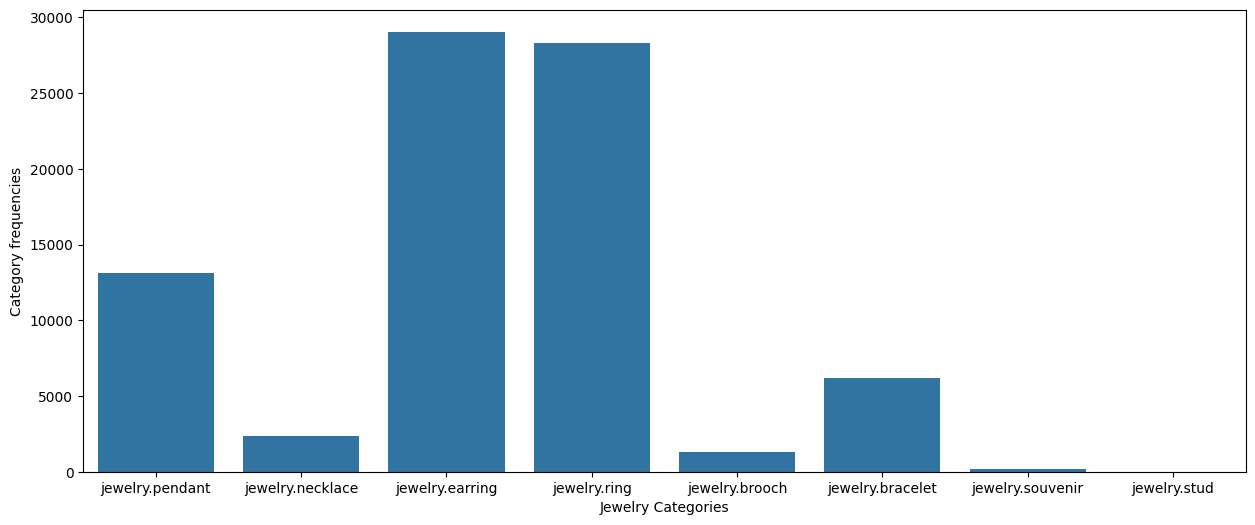

In [26]:
#category countplot
plt.figure(figsize = (15, 6))
sns.countplot(data=real_categories, x='category' )
plt.xlabel('Jewelry Categories')
plt.ylabel('Category frequencies');

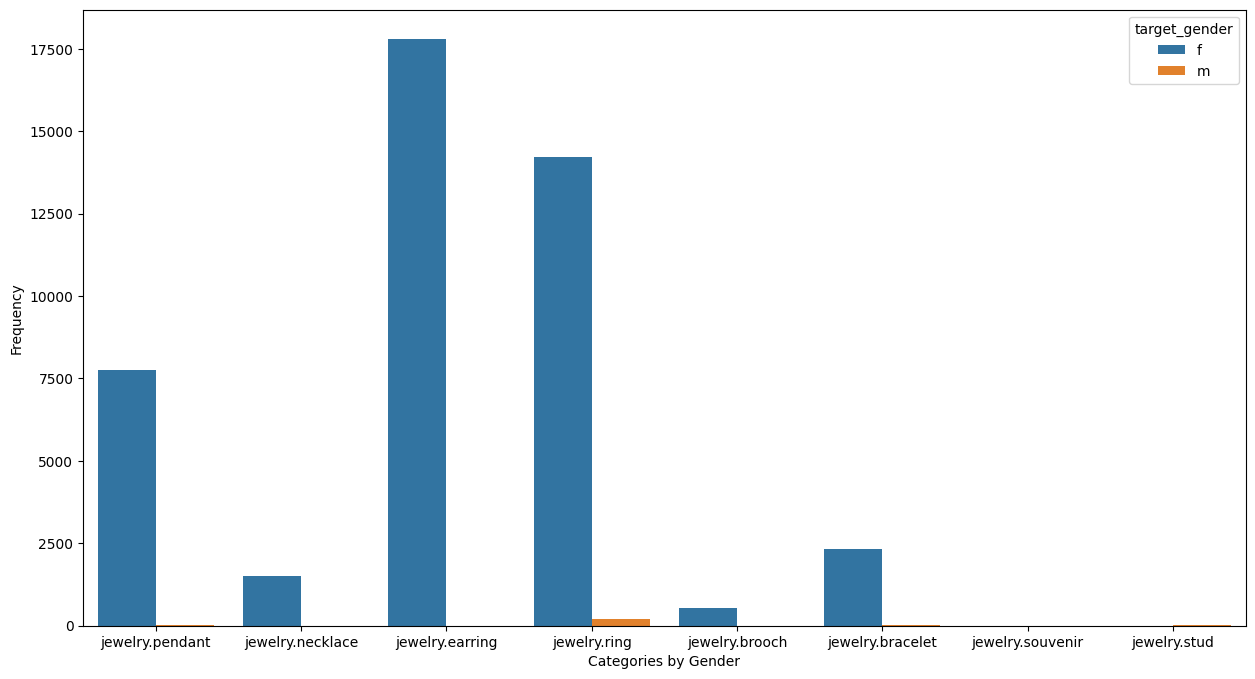

In [27]:
#breakdown jewelry category by gender
real_categories.groupby('category')['target_gender'].sum
plt.figure(figsize = (15,8))
sns.countplot(data=real_categories, x='category', hue='target_gender')
plt.xlabel('Categories by Gender')
plt.ylabel('Frequency');


### Next stop is correlation but since most of our data are in categorical format, they need to be transformed into numerical form

In [28]:
#factorize allows us represent text in numbers
#encode jewelry categories
encoded, category_code = pd.factorize(real_categories['category'])
real_categories.loc[:, 'category'] = encoded

In [29]:
#encode gender
encoded, category_code = pd.factorize(real_categories['target_gender'])
real_categories.loc[:, 'target_gender'] = encoded

In [30]:

#encode main gem
encoded, category_code = pd.factorize(real_categories['main_gem'])
real_categories.loc[:, 'main_gem'] = encoded

In [31]:
#encode main color
encoded, category_code = pd.factorize(real_categories['main_color'])
real_categories.loc[:, 'main_color'] = encoded

In [32]:
#encode main metal
encoded, category_code = pd.factorize(real_categories['main_metal'])
real_categories.loc[:, 'main_metal'] = encoded

In [33]:
real_categories.head()

,order_datetime,order_id,product_id,sku_quantity,category_id,category,brand_id,price_usd,user_id,target_gender,main_color,main_gem,main_metal
1,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,0,1.0,54.66,1.515916e+18,0,0,0,0
2,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,0,0.0,88.90,1.515916e+18,0,1,0,1
3,2018-12-02 21:30:19 UTC,1925740842841014667,1873936840742928865,1,1.806829e+18,1,0.0,417.67,1.515916e+18,-1,1,0,2
4,2018-12-02 22:09:34 UTC,1925760595336888995,1835566854827934449,1,1.806829e+18,2,1.0,102.27,1.515916e+18,-1,1,0,-1
5,2018-12-02 22:09:34 UTC,1925760595336888995,1600021442638905547,1,1.806829e+18,2,0.0,150.55,1.515916e+18,-1,1,0,1


In [34]:
data.head()

,order_datetime,order_id,product_id,sku_quantity,category_id,category,brand_id,price_usd,user_id,target_gender,main_color,main_gem,main_metal
0,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
1,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
2,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond
3,2018-12-02 21:30:19 UTC,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst
4,2018-12-02 22:09:34 UTC,1925760595336888995,1835566854827934449,1,1.806829e+18,jewelry.earring,1.0,102.27,1.515916e+18,NaN,red,gold,NaN


In [35]:
#feature correlation
correlations = real_categories.drop(labels=['order_datetime','order_id','product_id','user_id'], axis =1).corr(method='spearman')

In [36]:

correlations #most of the features are not strongly correlated. Our Price also doesn't shpw strong correlation. All in all, we have weak to moderate corellation within our features

,sku_quantity,category_id,category,brand_id,price_usd,target_gender,main_color,main_gem,main_metal
sku_quantity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_id,NaN,1.000000,-0.886212,0.111328,-0.296495,0.106286,0.003396,0.157834,0.050483
category,NaN,-0.886212,1.000000,-0.111680,0.267257,-0.124101,-0.059402,0.105056,-0.082944
brand_id,NaN,0.111328,-0.111680,1.000000,-0.018428,0.623701,0.100816,0.003835,0.076277
price_usd,NaN,-0.296495,0.267257,-0.018428,1.000000,0.049532,0.013177,-0.173050,-0.006630
target_gender,NaN,0.106286,-0.124101,0.623701,0.049532,1.000000,0.056950,-0.046436,0.166125
main_color,NaN,0.003396,-0.059402,0.100816,0.013177,0.056950,1.000000,-0.238080,0.136232
main_gem,NaN,0.157834,0.105056,0.003835,-0.173050,-0.046436,-0.238080,1.000000,-0.055603
main_metal,NaN,0.050483,-0.082944,0.076277,-0.006630,0.166125,0.136232,-0.055603,1.000000


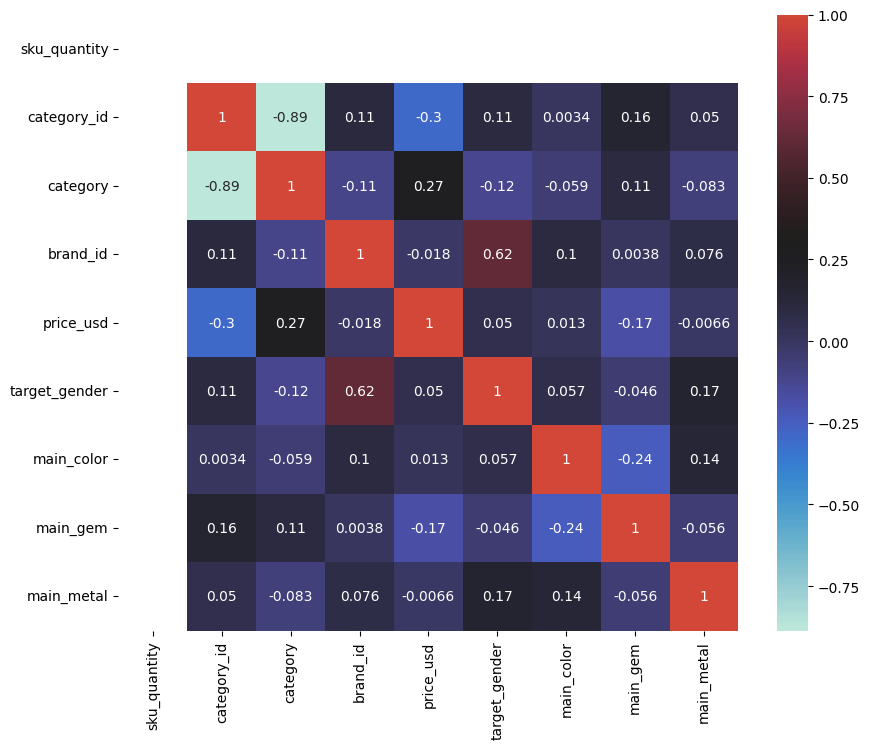

In [37]:
#visualizing the correlation as heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlations, annot=True, center=.3);

In [38]:
# Define correlation limits
upper = 1
lower = 0.2

# Identify columns that are correlated within the specified range
correlated_columns = {
    column: correlations[(correlations[column] > lower) & (correlations[column] < upper)].index.tolist()
    for column in correlations.columns
}

# Print the result
for key, value in correlated_columns.items():
    print(f"{key}: {value}")


sku_quantity: []
category_id: []
category: ['price_usd']
brand_id: ['target_gender']
price_usd: ['category']
target_gender: ['brand_id']
main_color: []
main_gem: []
main_metal: []


From our data findings' we can imply that:
There are missing values and some of the files are corrupted.
Presence of rare values
some features have very low cardinality(a singular feature)
a skewed target i.e skewed towards the right
correlation: low multicolineariy. however the target variable which is the price usd has a low correlation with the feature variables

In [39]:
columns_to_eliminate = ['order_id','product_id','sku_quantity','category_id','user_id']

In [40]:
data.drop(columns= columns_to_eliminate, inplace = True)

In [41]:
data.head()

,order_datetime,category,brand_id,price_usd,target_gender,main_color,main_gem,main_metal
0,2018-12-01 17:38:31 UTC,NaN,NaN,212.14,NaN,yellow,gold,NaN
1,2018-12-02 13:53:42 UTC,jewelry.pendant,1.0,54.66,f,white,gold,sapphire
2,2018-12-02 17:44:02 UTC,jewelry.pendant,0.0,88.90,f,red,gold,diamond
3,2018-12-02 21:30:19 UTC,jewelry.necklace,0.0,417.67,NaN,red,gold,amethyst
4,2018-12-02 22:09:34 UTC,jewelry.earring,1.0,102.27,NaN,red,gold,NaN


In [42]:
data.drop(columns = 'order_datetime', inplace = True)

In [43]:
data.head()

,category,brand_id,price_usd,target_gender,main_color,main_gem,main_metal
0,NaN,NaN,212.14,NaN,yellow,gold,NaN
1,jewelry.pendant,1.0,54.66,f,white,gold,sapphire
2,jewelry.pendant,0.0,88.90,f,red,gold,diamond
3,jewelry.necklace,0.0,417.67,NaN,red,gold,amethyst
4,jewelry.earring,1.0,102.27,NaN,red,gold,NaN


In [44]:
data.shape

(95910, 7)

In [45]:
#eliminate unrealistic categories
data = data.loc[data['category'].isin(categories)]

In [46]:
data.shape
#a lot of the rows were corrupted

(80458, 7)

In [47]:
 #identifying features and target
 X = data.drop(columns = 'price_usd')
 y= data['price_usd']
y

1         54.66
2         88.90
3        417.67
4        102.27
5        150.55
          ...  
95900    145.62
95903    301.23
95907    630.00
95908     83.42
95909     97.12
Name: price_usd, Length: 80458, dtype: float64

In [62]:
#splitting data into train and test features
X_train, X_test, y_train ,y_test = train_test_split(X,y, test_size = 0.1)

## Data Modeling
This will be done with 4 different models:
a) Linear Regression
b) Extremely Random Forest
c) Adaptive boosting
d) Catboost

In [51]:
def generate_pipeline(model, column_indices, categorical_indices, fill_missing=True, one_hot=True, label_encode=False):
    # Create the transformer for imputing missing values
    first_transformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='most_frequent'), column_indices)
        ],
        remainder='passthrough',
        sparse_threshold=0
    )

    # Create the transformer for one-hot encoding
    second_transformer = ColumnTransformer(
        transformers=[
            ('one_hot', OneHotEncoder(), categorical_indices)
        ],
        remainder='passthrough',
        sparse_threshold=0
    )

    # Create the transformer for ordinal encoding
    third_transformer = ColumnTransformer(
        transformers=[
            ('ordinal', OrdinalEncoder(), categorical_indices)
        ],
        remainder='passthrough',
        sparse_threshold=0
    )

    # Initialize the list of steps for the pipeline
    steps = []

    # Conditionally add transformers to the pipeline steps
    if fill_missing:
        steps.append(('impute', first_transformer))
    if label_encode:
        steps.append(('ordinal', third_transformer))
    if one_hot:
        steps.append(('one_hot', second_transformer))

    steps.append(('model', model))

    # Create the pipeline with the specified steps
    model_pipe = Pipeline(steps=steps)

    return model_pipe


In [52]:
#Generate indices
columns = X.columns.tolist()
column_indices = [columns.index(c) for c in columns]
categorical_features = [c for c in columns if c not in ['brand_id']]
categorical_indices = [columns.index(c) for c in categorical_features]
categorical_indices

[0, 2, 3, 4, 5]

In [53]:
#Instantiating pipeline with our 5 different models
#Catboost Pipeline
cat_pipe = generate_pipeline(
    CatBoostRegressor(loss_function = 'RMSE', iterations = 10000, learning_rate = 0.1, one_hot_max_size = 2),
    column_indices,
    categorical_indices,
    fill_missing=False, one_hot=False, label_encode= True)

In [54]:
#Instantiate Linear Regression
lin_pipe = generate_pipeline(
    LinearRegression(),
    column_indices,
    categorical_indices,
    fill_missing=True, one_hot=True, label_encode= False)

In [55]:
#Instatiate AdaBoost pipeline
ada_pipe = generate_pipeline(
    AdaBoostRegressor(loss = 'exponential',n_estimators = 1000, learning_rate = 0.1),
    column_indices,
    categorical_indices,
    fill_missing=True, one_hot=True, label_encode= False)


In [58]:
#Instatiate extratrees pipeline
extra_pipe = generate_pipeline(
    ExtraTreesRegressor(criterion = "friedman_mse", n_estimators = 1000, bootstrap = True),
    column_indices,
    categorical_indices,
    fill_missing=True, one_hot=True, label_encode= False)


In [59]:
#Transform Targets
cat_pipe = TransformedTargetRegressor(regressor = cat_pipe, transformer = PowerTransformer(method = 'box-cox'))
lin_pipe = TransformedTargetRegressor(regressor = lin_pipe, transformer = PowerTransformer(method = 'box-cox'))
ada_pipe = TransformedTargetRegressor(regressor = ada_pipe, transformer = PowerTransformer(method = 'box-cox'))
extra_pipe = TransformedTargetRegressor(regressor = extra_pipe, transformer = PowerTransformer(method ='box-cox'))

In [67]:
#fit Cat boost
cat_pipe.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
5000:	learn: 0.6147845	total: 58.6s	remaining: 58.6s
5001:	learn: 0.6147845	total: 58.6s	remaining: 58.6s
5002:	learn: 0.6147841	total: 58.6s	remaining: 58.6s
5003:	learn: 0.6147839	total: 58.6s	remaining: 58.6s
5004:	learn: 0.6147835	total: 58.7s	remaining: 58.5s
5005:	learn: 0.6147831	total: 58.7s	remaining: 58.5s
5006:	learn: 0.6147829	total: 58.7s	remaining: 58.5s
5007:	learn: 0.6147827	total: 58.7s	remaining: 58.5s
5008:	learn: 0.6147823	total: 58.7s	remaining: 58.5s
5009:	learn: 0.6147822	total: 58.7s	remaining: 58.5s
5010:	learn: 0.6147822	total: 58.7s	remaining: 58.5s
5011:	learn: 0.6147812	total: 58.7s	remaining: 58.4s
5012:	learn: 0.6147812	total: 58.7s	remaining: 58.4s
5013:	learn: 0.6147811	total: 58.8s	remaining: 58.4s
5014:	learn: 0.6147811	total: 58.8s	remaining: 58.4s
5015:	learn: 0.6147802	total: 58.8s	remaining: 58.4s
5016:	learn: 0.6147802	total: 58.8s	remaining: 58.4s
5017:	learn: 0.6147801	total: 58.8s	remaining: 5

TransformedTargetRegressor(regressor=Pipeline(steps=[('ordinal',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('ordinal',
                                                                                       OrdinalEncoder(),
                                                                                       [0,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('model',
                                                      <catboost.core.CatBoostRegressor object at 0x791d95a04f70>)]),
                           transformer=PowerTransformer(method='box-cox'))

In [64]:
#fit LR
lin_pipe.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('impute',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('imputer',
                                                                                       SimpleImputer(strategy='most_frequent'),
                                                                                       [0,
                                                                                        1,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('one_hot',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('one_hot',
                                                                                       OneHotEncoder(),
                                                                                       [0,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=PowerTransformer(method='box-cox'))

In [65]:
#fit Adaboost
ada_pipe.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('impute',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('imputer',
                                                                                       SimpleImputer(strategy='most_frequent'),
                                                                                       [0,
                                                                                        1,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('one_hot',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('one_hot',
                                                                                       OneHotEncoder(),
                                                                                       [0,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('model',
                                                      ExtraTreesRegressor(bootstrap=True,
                                                                          criterion='friedman_mse',
                                                                          n_estimators=1000))]),
                           transformer=PowerTransformer(method='box-cox'))

In [66]:
#fit extra trees
extra_pipe.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('impute',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('imputer',
                                                                                       SimpleImputer(strategy='most_frequent'),
                                                                                       [0,
                                                                                        1,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('one_hot',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        sparse_threshold=0,
                                                                        transformers=[('one_hot',
                                                                                       OneHotEncoder(),
                                                                                       [0,
                                                                                        2,
                                                                                        3,
                                                                                        4,
                                                                                        5])])),
                                                     ('model',
                                                      ExtraTreesRegressor(bootstrap=True,
                                                                          criterion='friedman_mse',
                                                                          n_estimators=1000))]),
                           transformer=PowerTransformer(method='box-cox'))

## Model Evaluation
1. R2
2. RMSE

In [69]:
def root_mean_squared_error(y_true, y_pred):
  value = mean_squared_error(y_true, y_pred)
  return np.sqrt(value)

In [70]:
def generate_model_score(model,data, metric_function):
  X, y = data
  y_pred = model.predict(X)
  score = metric_function(y, y_pred)
  return score

In [72]:
def print_metrics(metric_name, train_score, test_score):
  print(f"{metric_name} score on training data: {train_score}")
  print(f"{metric_name} score on test data: {test_score}")
  print (f"Generalization error = {train_score - test_score}")
  return

In [92]:
def test_model(model, data, metric_name, metric_function):
    # Assuming data is a tuple (train, test)
    train, test = data

    if isinstance(metric_name, str):
        train_score = generate_model_score(model, train, metric_function)
        test_score = generate_model_score(model, test, metric_function)
        print_metrics(metric_name, train_score, test_score)

    else:  # Multiple metrics
        for name, function in zip(metric_name, metric_function):
            train_score = generate_model_score(model, train, function)
            test_score = generate_model_score(model, test, function)
            print_metrics(name, train_score, test_score)

    return


In [93]:
#Name and functions of metrics
metric_name = ['R2', 'RMSE']
metric_function = [r2_score, root_mean_squared_error]

In [94]:
#create data variable
data_ = [
    [X_train, y_train],
    [X_test, y_test]
]

In [95]:
#Test CatBoost
test_model(cat_pipe, data_, metric_name, metric_function)

R2 score on training data: 0.32054957499719317
R2 score on test data: 0.3069715992461717
Generalization error = 0.013577975751021487
RMSE score on training data: 367.09300208586626
RMSE score on test data: 325.0142904765798
Generalization error = 42.07871160928647


In [96]:
#test LR
test_model(lin_pipe, data_, metric_name, metric_function)

R2 score on training data: 0.06868065002568646
R2 score on test data: 0.08935813373709134
Generalization error = -0.020677483711404876
RMSE score on training data: 429.7803264966067
RMSE score on test data: 372.5638792090213
Generalization error = 57.21644728758537


In [97]:
#test adaboost
test_model(ada_pipe, data_, metric_name, metric_function)

R2 score on training data: 0.221713004805988
R2 score on test data: 0.17751659559087973
Generalization error = 0.04419640921510826
RMSE score on training data: 392.88649897656063
RMSE score on test data: 354.07112620459367
Generalization error = 38.81537277196696


In [98]:
#test extratrees
test_model(extra_pipe, data_, metric_name, metric_function)

R2 score on training data: 0.22170510901279794
R2 score on test data: 0.17747979118246116
Generalization error = 0.044225317830336786
RMSE score on training data: 392.8884919063503
RMSE score on test data: 354.0790480863543
Generalization error = 38.80944381999598


## Model Deployment.
It can be observed that the Cat Boost model performed the best out of the other model however the R2 score (0.32) performed poorly and is not good enough.
It is important to note that not all problems can be solved with machine learning. However few recommendations can be made:
a - An encompassing datasets. Our datasets had few features which were mostly categorical in nature making it quite scanty.
b - Obtain better, cleaner and more integral datasets.
c- They should get larger datasets seeing as from EDA a huge chunk of our data was corrupt.

